# DGL简单示例
## 在DGL中创建图

In [1]:
import matplotlib.pyplot as plt
import dgl
def build_graph():
    g = dgl.DGLGraph()
    g.add_nodes(34)  # 0-5节点
    edge_list = [(1, 0), (2, 0), (2, 1), (3, 0), (3, 1), (3, 2),
        (4, 0), (5, 0), (6, 0), (6, 4), (6, 5), (7, 0), (7, 1),
        (7, 2), (7, 3), (8, 0), (8, 2), (9, 2), (10, 0), (10, 4),
        (10, 5), (11, 0), (12, 0), (12, 3), (13, 0), (13, 1), (13, 2),
        (13, 3), (16, 5), (16, 6), (17, 0), (17, 1), (19, 0), (19, 1),
        (21, 0), (21, 1), (25, 23), (25, 24), (27, 2), (27, 23),
        (27, 24), (28, 2), (29, 23), (29, 26), (30, 1), (30, 8),
        (31, 0), (31, 24), (31, 25), (31, 28), (32, 2), (32, 8),
        (32, 14), (32, 15), (32, 18), (32, 20), (32, 22), (32, 23),
        (32, 29), (32, 30), (32, 31), (33, 8), (33, 9), (33, 13),
        (33, 14), (33, 15), (33, 18), (33, 19), (33, 20), (33, 22),
        (33, 23), (33, 26), (33, 27), (33, 28), (33, 29), (33, 30),
        (33, 31), (33, 32)]
    src, dst = tuple(zip(*edge_list))
    g.add_edges(src, dst)
    g.add_edges(dst, src)
    return g

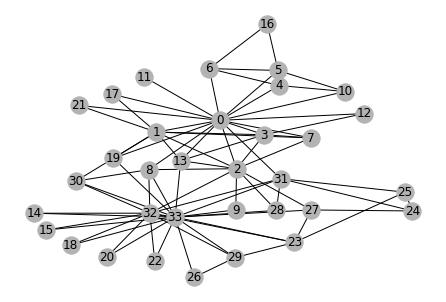

In [2]:
import networkx as nx
G = build_graph()
nx_G = G.to_networkx().to_undirected()
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

## 创建节点特征

In [3]:
import torch
G.ndata['feat'] = torch.eye(34)
print(G.nodes[0].data['feat'])
print(G.nodes[[2, 3]].data['feat'])

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


## 图卷积网络

In [4]:
import torch.nn as nn
import torch.nn.functional as F

def gcn_message(edges):
    return {'msg': edges.src['h']}

def gcn_reduce(nodes):
    return {'h': torch.sum(nodes.mailbox['msg'], dim=1)}

class GCNLayer(nn.Module):
    def __init__(self, in_feat, out_feat):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feat, out_feat)
    def forward(self, g, inputs):
        g.ndata['h'] = inputs
        g.send(g.edges(), gcn_message)
        g.recv(g.nodes(), gcn_reduce)
        h = g.ndata.pop('h')
        return self.linear(h)

In [5]:
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.gcn1 = GCNLayer(in_feats, hidden_size)
        self.gcn2 = GCNLayer(hidden_size, num_classes)
    def forward(self, g, inputs):
        h = self.gcn1(g, inputs)
        h = torch.relu(h)
        h = self.gcn2(g, h)
        return h

## 准备训练数据

In [6]:
inputs = torch.eye(34)
labeled_nodes = torch.tensor([0, 33])
labels = torch.tensor([0, 1])

## 训练

In [7]:
net = GCN(34, 5, 2)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
criterion = nn.NLLLoss()
all_logits = []
for epoch in range(30):
    logits = net(G, inputs)
    all_logits.append(logits.detach())
    p = F.log_softmax(logits, 1)
    loss = criterion(p[labeled_nodes], labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print('Epoch:', epoch, ' | Loss:', loss.item())

Epoch:0 | Loss:0.4024065136909485
Epoch:1 | Loss:0.29729485511779785
Epoch:2 | Loss:0.21348795294761658
Epoch:3 | Loss:0.14667180180549622
Epoch:4 | Loss:0.09399789571762085
Epoch:5 | Loss:0.057343631982803345
Epoch:6 | Loss:0.03322117403149605
Epoch:7 | Loss:0.018754808232188225
Epoch:8 | Loss:0.010762152262032032
Epoch:9 | Loss:0.0063651809468865395
Epoch:10 | Loss:0.003906138241291046
Epoch:11 | Loss:0.0024754670448601246
Epoch:12 | Loss:0.0016175041673704982
Epoch:13 | Loss:0.0010850653052330017
Epoch:14 | Loss:0.0007471012650057673
Epoch:15 | Loss:0.0005302438512444496
Epoch:16 | Loss:0.0003856046823784709
Epoch:17 | Loss:0.00028670288156718016
Epoch:18 | Loss:0.0002177033165935427
Epoch:19 | Loss:0.00016860170580912381
Epoch:20 | Loss:0.00013302502338774502
Epoch:21 | Loss:0.00010698210098780692
Epoch:22 | Loss:8.731525304028764e-05
Epoch:23 | Loss:7.259457925101742e-05
Epoch:24 | Loss:6.115158612374216e-05
Epoch:25 | Loss:5.221162791713141e-05
Epoch:26 | Loss:4.5178781874710694e

## 可视化

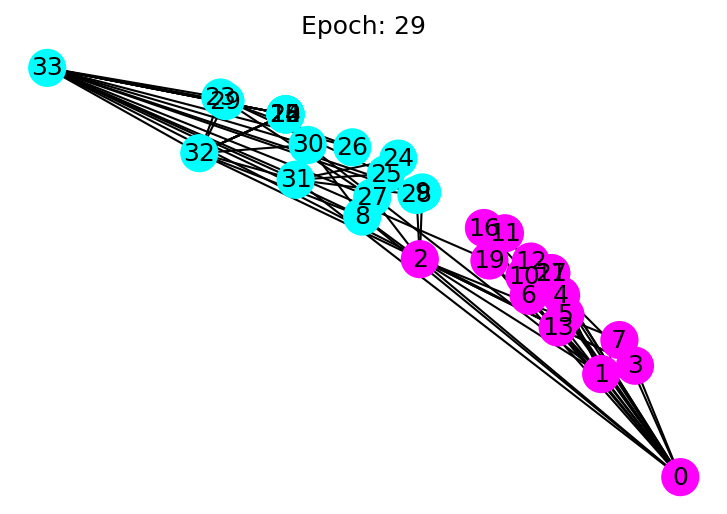

In [8]:
import matplotlib.animation as animation
def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(34):
        pos[v] = all_logits[i][v].numpy()
        cls = pos[v].argmax()
        colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw_networkx(nx_G.to_undirected(), pos, node_color=colors,
            with_labels=True, node_size=300, ax=ax)

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
draw(29)  # draw the prediction of the first epoch
plt.show()
plt.close()

In [9]:
ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=200)